# Deep Learning - **Homework #2**

* Teching assistant email: trung@uef.fi
* Deadline: **23:59 - 14/12/2019 (UPDATED)**
* Maximum: **5 points**

Goals:

* Understand the important roles of activation function in deep neural network
* Understand the difficulty of training a neural network
* Implement your first recurrent neural network
* Familar with the procedure for training and evaluating your deep learning model

References:

1. He, K., Zhang, X., Ren, S., Sun, J., 2015. ["Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification"](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf). arXiv:1502.01852 [cs].
2. Misra, D., 2019.["Mish: A Self Regularized Non-Monotonic Neural Activation Function"](https://arxiv.org/pdf/1908.08681.pdf). arXiv:1908.08681 [cs, stat].
3. Glorot, X., Bengio, Y., n.d. ["Understanding the difficulty of training deep feedforward neural networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)
4. Pascanu, R., Mikolov, T., Bengio, Y., 2013. ["On the difficulty of training recurrent neural networks"](http://proceedings.mlr.press/v28/pascanu13.pdf). Proceedings of Machine Learning Research.
5. Andrej Karpathey, 2015. ["The Unreasonable Effectiveness of Recurrent Neural Networks"](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

How to submit:

* Option#1: **File** $\to$ **Download .ipynb** $\to$ _Send to .ipynb file to my email, or submit it to moodle page_.
* Option#2: **Share** read-only notebook link to my email.
* _If you choose to share the notebook, please re-name the notebook to your student name and student number, I will take the snapshot of your notebook before the deadline, any modification afterward will be disregarded._

**NOTE**: This is official homework and will be graded

In [0]:
# All libraries we use for this HW, run this block first!
%tensorflow_version 2.x
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import torch
from matplotlib import pyplot as plt
from sklearn import datasets, neural_network
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix
np.random.seed(8)

# Question 1: The _"Fantastic activation functions and where to find them"_


### **a)** Finish the implementation of each activation function and their derivative.

Sigmoid function: $f(x) = \frac{1}{1+e^{-x}}$

Tanh function: $f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$

ReLU (or rectifier) function: description at [Delving Deep into Rectifiers:
Surpassing Human-Level Performance on ImageNet Classification](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) (NOTE: you only need ReLU, not PReLU or LReLU)

Mish function: description at ["Mish: A Self Regularized Non-Monotonic Neural Activation Function"](https://arxiv.org/pdf/1908.08681.pdf)

In [0]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def derivative_sigmoid(x):
  return sigmoid(x) * (1 - sigmoid(x))

def tanh(x):
  return (np.exp(2 * x) - 1) / (np.exp(2 * x) + 2)

def derivative_tanh(x):
  return 1 - np.power(np.tanh(x), 2)

def relu(x):
  return np.maximum(0, x)

def derivative_relu(x):
  return np.where(x <= 0, 0, 1)

def mish(x):
  return x * tanh(np.log(1 + np.exp(x)))

def derivative_mish(x):
  omega = 4 * (x + 1) + 4 * np.exp(2 * x) + np.exp(
      3 * x) + np.exp(x) * (4 * x + 6)
  delta = 2 * np.exp(x) + np.exp(2 * x) + 2
  return np.exp(x) * omega / delta**2

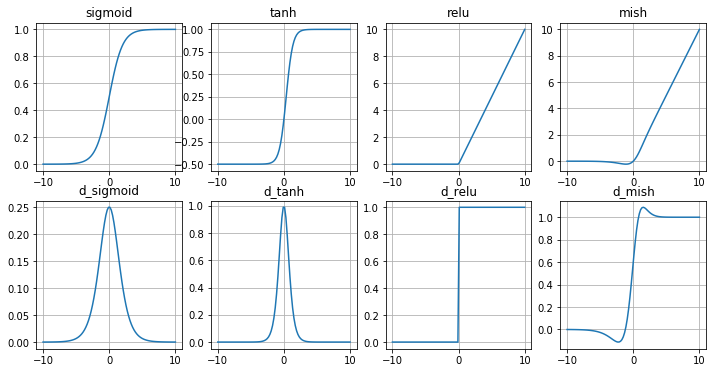

In [0]:
#@title Run this block to debug your functions
activation = ['sigmoid', 'tanh', 'relu', 'mish']
n = len(activation)
x = np.linspace(-10, 10, num=100)
plt.figure(figsize=(12, 6))
for i, name in enumerate(activation):
  try:
    y = locals()[name](x)
    dy_x = locals()['derivative_' + name](x)
  except:
    try:
      y = locals()[name](torch.from_numpy(x))
      dy_x = locals()['derivative_' + name](torch.from_numpy(x))
    except:
      try:
        y = locals()[name](tf.convert_to_tensor(x))
        dy_x = locals()['derivative_' + name](tf.convert_to_tensor(x))
      except:
        pass
  if hasattr(y, 'numpy'):
    y = y.numpy()
  if hasattr(dy_x, 'numpy'):
    dy_x = dy_x.numpy()
    
  plt.subplot(2, n, i + 1)
  if y is not None:
    plt.plot(x, y)
  plt.grid(True)
  plt.title(name)

  plt.subplot(2, n, i + n + 1)
  if dy_x is not None:
    plt.plot(x, dy_x)
  plt.grid(True)
  plt.title('d_' + name)

### **b)** Selecting the appropriate activation function for the following multilayer perceptron

In [0]:
# the output is probability values, so logistic or softmax activation is important.
X, y = datasets.load_wine(return_X_y=True)
mlp = neural_network.MLPClassifier(activation='logistic')
mlp.fit(X, y)
print("Accuracy:", accuracy_score(y_true=y, y_pred=mlp.predict(X)))
# You must be able to get > 90% accuracy for this task

Accuracy: 0.949438202247191


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [0]:
# The housing price is always positive, so relu activation make sense
X, y = datasets.load_boston(return_X_y=True)
mlp = neural_network.MLPRegressor(activation='relu')
mlp.fit(X, y)
print("MSE:", mean_squared_error(y_true=y, y_pred=mlp.predict(X)))
# you must be able to get MSE < 30 for this task

MSE: 27.849020204988143


# Question 2: _The curious case of vanishing gradients_

Finish the implementation of `recurrent_neural_network` (i.e. filling in the **TODO** line in the code)

Then, run the following code block with two different `activation` for the function `recurrent_neural_network` (i.e. line 42)

* `outputs = recurrent_neural_network(X, activation=torch.sigmoid)`
* and `outputs = recurrent_neural_network(X, activation=lambda x: x)` (i.e. the identity function`

Answer the following question:

*   Explain what wrong with the gradients of the parameters ($W_h$, $W_x$, and $bias$).
*   What is the solution for these issues? 

Modifying the code according to your solution

**TIPS**: check out these _cool_ papers

*   [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)
*   [On the difficulty of training recurrent neural networks](http://proceedings.mlr.press/v28/pascanu13.pdf)
*   [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)


**NOTE**: the recurrent neural network is implemented as following.

![alt text](https://drive.google.com/uc?export=view&id=1SMpJWb0h5ElMfXYdRnd0Gu6OsmPKwy-c)

---

The gradient values are _vanishing_ (i.e. going down to zeros). However, Gradient $W_x$ is much _noticable_ compared to $W_h$ or the bias. From the equation, we could see $W_h$ interact with $h_{t-1}$, and $W_x$ interact with $x_t$. Therefore, the gradient $W_h$ significantly depend on the previous timestep of the hidden stage while $W_x$ receive new information from the input everytime. As we known, the effect of gradient vanishing or exploding is magnified as the number of timestep increasing.

Three main solution are proposed:

* Using more robust activation (i.e. `ReLU`)
* Truncate gradient in time, i.e. only select a fixed number of timestep to backpropagate gradient signal. For instance, we choose a maximum of 10 timesteps, when inputing a sequence of length 12, the error coursed by the last two are ignored.
* Create a more robust recurrent structure, for example, Long-short term memory network (LSTM) uses gating mechanism to **add** new information to the temopral pattern. Since the new information is added, not multiplied, it is less likely to vanish or explode.


Training  Epoch#0  Loss: 0.5131
Training  Epoch#10  Loss: 0.3406
Training  Epoch#20  Loss: 0.2882
Training  Epoch#30  Loss: 0.1788
Training  Epoch#40  Loss: 0.1643
Training  Epoch#50  Loss: 0.1564
Training  Epoch#60  Loss: 0.1392
Training  Epoch#70  Loss: 0.1286
Training  Epoch#80  Loss: 0.1272
Training  Epoch#90  Loss: 0.1266
Training  Epoch#100  Loss: 0.1263
Training  Epoch#110  Loss: 0.1261
Training  Epoch#120  Loss: 0.1260
Training  Epoch#130  Loss: 0.1259
Training  Epoch#140  Loss: 0.1258
Training  Epoch#150  Loss: 0.1257
Training  Epoch#160  Loss: 0.1257
Training  Epoch#170  Loss: 0.1256
Training  Epoch#180  Loss: 0.1256
Training  Epoch#190  Loss: 0.1255


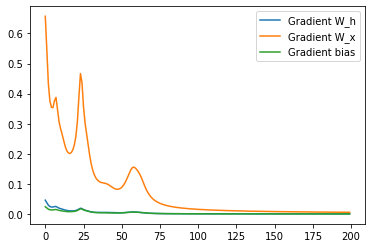

In [0]:
#@title If you are more familiar with Pytorch, use this block
hidden_units = 8
n_samples = 12
n_time = 128
n_features = 18

# just randomize data for our optimization
X = torch.from_numpy(
    12 * np.random.rand(n_samples, n_time, n_features).astype('float32'))
target = torch.from_numpy(
    np.random.randint(0, 10, size=(n_samples,)).astype('float32'))

# initialize the weight and bias
W_h = torch.nn.init.xavier_normal_(
    torch.zeros(hidden_units, hidden_units, requires_grad=True))
W_x = torch.nn.init.xavier_normal_(
    torch.zeros(hidden_units, n_features, requires_grad=True))
bias = torch.zeros(hidden_units, 1, requires_grad=True)


def recurrent_neural_network(x, activation):
  # x : [number_of_samples, time_dimension, number_of_features]
  n_samples, n_timedim, n_features = x.shape
  # initial the first state at time step zero 
  h0 = torch.zeros(n_samples, hidden_units)

  h = h0
  for time_step in torch.arange(0, x.shape[1]):
    # TODO: finish the implementation of recurrent neural network here, 
    # make sure the final output `h` has shape [n_samples, hidden_units]
    x_t = x[:, time_step, :]
    h = activation(W_h @ h.T + W_x @ x_t.T + bias).T
  # we only need the last time step for classification task
  return h

#### Create the optimizer training our RNN
optimizer = torch.optim.SGD(params=[W_h, W_x, bias], lr=0.1)
mse = torch.nn.modules.loss.MSELoss()

grad_Wh = []
grad_Wx = []
grad_bias = []
for epoch in range(200):  # loop over the dataset multiple times
  # zero the parameter gradients
  optimizer.zero_grad()
  # forward + backward + optimize
  outputs = recurrent_neural_network(X, activation=torch.sigmoid)
  # just some dummy loss function
  loss = outputs.mean()
  loss.backward()
  # record the gradients of the parameters for plotting
  grad_Wh.append(torch.norm(W_h.grad))
  grad_Wx.append(torch.norm(W_x.grad))
  grad_bias.append(torch.norm(bias.grad))
  # optimizing the model
  optimizer.step()
  if epoch % 10 == 0:
    print("Training  Epoch#%d  Loss: %.4f" % (epoch, loss.detach().numpy()))

# visualize the gradient of the parameters during learning process.
plt.plot(grad_Wh, label='Gradient W_h')
plt.plot(grad_Wx, label='Gradient W_x')
plt.plot(grad_bias, label='Gradient bias')
plt.legend()

Training  Epoch#0  Loss: 0.5004
Training  Epoch#10  Loss: 0.2856
Training  Epoch#20  Loss: 0.1581
Training  Epoch#30  Loss: 0.0653
Training  Epoch#40  Loss: 0.0267
Training  Epoch#50  Loss: 0.0081
Training  Epoch#60  Loss: 0.0043
Training  Epoch#70  Loss: 0.0030
Training  Epoch#80  Loss: 0.0023
Training  Epoch#90  Loss: 0.0019
Training  Epoch#100  Loss: 0.0016
Training  Epoch#110  Loss: 0.0014
Training  Epoch#120  Loss: 0.0013
Training  Epoch#130  Loss: 0.0011
Training  Epoch#140  Loss: 0.0010
Training  Epoch#150  Loss: 0.0010
Training  Epoch#160  Loss: 0.0009
Training  Epoch#170  Loss: 0.0008
Training  Epoch#180  Loss: 0.0008
Training  Epoch#190  Loss: 0.0007


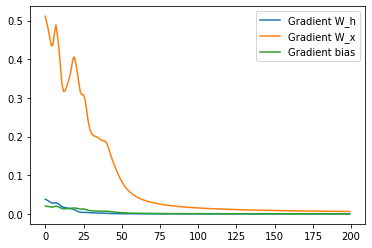

In [0]:
#@title If you are more familiar with tensorflow, use this block
hidden_units = 8
n_samples = 12
n_time = 128
n_features = 18

# just randomize data for our optimization
X = tf.convert_to_tensor(
    12 * np.random.rand(n_samples, n_time, n_features).astype('float32'))
target = tf.convert_to_tensor(
    np.random.randint(0, 10, size=(n_samples,)).astype('float32'))

# initialize the weight and bias
init = tf.initializers.glorot_normal()
W_h = tf.Variable(init((hidden_units, hidden_units)), trainable=True)
W_x = tf.Variable(init((hidden_units, n_features)), trainable=True)
bias = tf.Variable(np.zeros((hidden_units, 1)).astype('float32'),
                   trainable=True)


def recurrent_neural_network(x, activation):
  # x : [number_of_samples, time_dimension, number_of_features]
  n_samples, n_timedim, n_features = x.shape
  # initial the first state at time step zero
  h0 = tf.zeros((n_samples, hidden_units))

  h = h0
  for time_step in tf.range(0, x.shape[1]):
    # TODO: finish the implementation of recurrent neural network here,
    # make sure the final output `h` has shape [n_samples, hidden_units]
    x_t = x[:, time_step, :]
    h = activation(W_h @ tf.transpose(h) + W_x @ tf.transpose(x_t) + bias)
    h = tf.transpose(h)
  # we only need the last time step for classification task
  return h


#### Create the optimizer training our RNN
optimizer = tf.optimizers.SGD(learning_rate=0.1)

grad_Wh = []
grad_Wx = []
grad_bias = []
for epoch in range(200):  # loop over the dataset multiple times
  #
  with tf.GradientTape() as tape:
    outputs = recurrent_neural_network(X, activation=tf.sigmoid)
    # just some dummy loss function
    loss = tf.reduce_mean(outputs)
  grads = tape.gradient(loss, [W_h, W_x, bias])
  optimizer.apply_gradients(
      grads_and_vars=[(g, v) for g, v in zip(grads, [W_h, W_x, bias])])
  # record the gradients of the parameters for plotting
  grad_Wh.append(tf.norm(grads[0]))
  grad_Wx.append(tf.norm(grads[1]))
  grad_bias.append(tf.norm(grads[2]))
  if epoch % 10 == 0:
    print("Training  Epoch#%d  Loss: %.4f" % (epoch, loss.numpy()))

# visualize the gradient of the parameters during learning process.
plt.plot(grad_Wh, label='Gradient W_h')
plt.plot(grad_Wx, label='Gradient W_x')
plt.plot(grad_bias, label='Gradient bias')
plt.legend()

# Question 3: _Getting pragmatic_ - BP Neural network-based recognizing handwritten digits

**TIPS**: The following paper contains all the useful tricks for training neural network [Efficient Backprop](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)

**NOTE**: you must be able to get > 90% accuracy on **test data** for this task.

Image: (1797, 64)
Label: (1797,)
[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


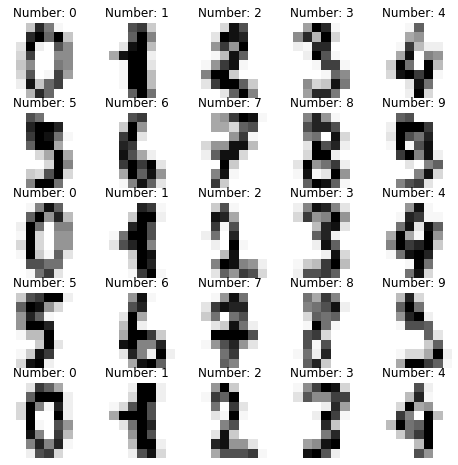

In [0]:
X, y = datasets.load_digits(return_X_y=True)
print("Image:", X.shape)
print("Label:", y.shape)
print(X[0].reshape(8, 8))

### Visualizing the training image
n = 0
plt.figure(figsize=(8, 8))
for i in range(5):
  for j in range(5):
    plt.subplot(5, 5, i * 5 + j + 1)
    plt.imshow(X[n].reshape(8, 8), cmap='Greys')
    plt.axis('off')
    plt.title("Number: %d" % y[n])
    n += 1

### **a)** Data preparation
Following the procedure in the following figure and split the given dataset appropriately!
![alt text](https://drive.google.com/uc?export=view&id=1gxet_ertq-yYiQLB9-PrCwoY_f8vF2HT)


In [0]:
# Your code for splitting the dataset
X_train, y_train = X[:1000], y[:1000]
X_valid, y_valid = X[1000:1200], y[1000:1200]
X_test, y_test = X[1200:], y[1200:]

### **b)** Using the back-propagation algorithm, design a multi-layer perceptron that classifiying the digit images.

In [0]:
# Your code here
def create_network():
  net = tf.keras.Sequential([
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(units=10, activation='softmax'),
  ])
  net.build((None, X.shape[1]))
  return net


def train_network(network,
                  X_train,
                  y_train,
                  X_valid,
                  y_valid,
                  n_epoch=32,
                  batch_size=64):
  n_iter = 0
  opt = tf.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
  for epoch in range(n_epoch):
    for batch in range(0, X_train.shape[0], batch_size):
      n_iter += 1
      # minibatch data
      X = X_train[batch:batch + batch_size]
      y = y_train[batch:batch + batch_size]

      # training loops
      with tf.GradientTape() as tape:
        y_pred = net(X)
        loss = tf.losses.categorical_crossentropy(y_true=tf.one_hot(y, 10),
                                                  y_pred=y_pred)
        loss = tf.reduce_mean(loss)
      grads = tape.gradient(loss, net.weights)
      opt.apply_gradients(
          grads_and_vars=[(g, w) for g, w in zip(grads, net.weights)])

      if n_iter % 20 == 0:
        y_valid_pred = network(X_valid)
        y_valid_pred = np.argmax(y_valid_pred.numpy(), axis=1)
        print("Training Loss:", loss.numpy(), "Validation Acc:",
              accuracy_score(y_true=y_valid, y_pred=y_valid_pred))


net = create_network()
train_network(net, X_train, y_train, X_valid, y_valid)

# evaluate on test set:
y_test_pred = net(X_test)
y_test_pred = np.argmax(y_test_pred.numpy(), axis=1)
print("Test Acc:", accuracy_score(y_true=y_test, y_pred=y_test_pred))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Training Loss: 1.5000906 Validation Acc: 0.44
Training Loss: 1.2098277 Validation Acc: 0.615
Training Loss: 0.6677424 Validation Acc: 0.75
Training Loss: 0.5770794 Validation Acc: 0.8
Training Loss: 0.43445748 Validation Acc: 0.815
Training Loss: 0.4368754 Validation Acc: 0.84
Training Loss: 0.26041913 Validation Acc: 0.845
Training Loss: 0.18437684 Validation Acc: 0.86
Training Loss: 0.2265303 Validation Acc: 0.87
Training Loss: 0.25974447 Validation Acc: 0.87
Training Loss: 0.16101232 Validation Acc: 

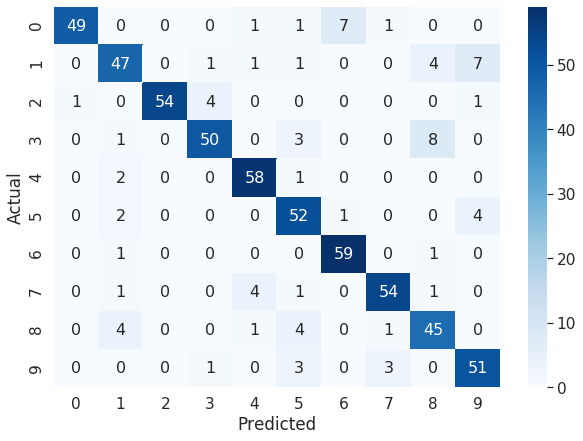

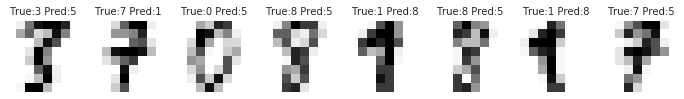

In [0]:
#@title Run this block to debug your network
if 'y_test_pred' in locals() and 'y_test' in locals():
  ### showing the confusion matrix
  data = confusion_matrix(y_test, y_test_pred)
  df_cm = pd.DataFrame(data,
                       columns=np.unique(y_test),
                       index=np.unique(y_test_pred))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize=(10, 7))
  sns.set(font_scale=1.4)  #for label size
  sns.heatmap(df_cm, cmap="Blues", annot=True,
              annot_kws={"size": 16})  # font size

  ### showing the misclassified cases
  indices = y_test_pred != y_test
  X_samples = X_test[indices].reshape(-1, 8, 8)
  y_samples_true = y_test[indices]
  y_samples_pred = y_test_pred[indices]
  plt.figure(figsize=(12, 4))
  for i in range(8):
    plt.subplot(1, 8, i + 1)
    if i + 1 < len(indices):
      plt.imshow(X_samples[i], cmap='Greys')
      plt.axis('off')
      plt.title("True:%d Pred:%d" % (y_samples_true[i], y_samples_pred[i]),
                fontsize=10)

### **c)** Use the normalization technique (pre-processing and post-processing) to speed up the training procedure, and make a comparison with the non-normalization approach.

In [0]:
# Normalize X_train, X_valid, X_test here
print(np.max(X_train))
X_train_norm = (X_train / 16.0  - 0.5) * 2.
X_valid_norm = (X_valid / 16.0 - 0.5) * 2.
X_test_norm = (X_test / 16.0 - 0.5) * 2.

# train with normalized data
net = create_network()
net.compile('adam', 'sparse_categorical_crossentropy', ['accuracy'])
net.fit(X_train_norm, y_train, validation_data=(X_valid_norm, y_valid), epochs=12, batch_size=128)
print("Test set:", net.evaluate(X_test_norm, y_test))

# train with original data
net = create_network()
net.compile('adam', 'sparse_categorical_crossentropy', ['accuracy'])
net.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=12, batch_size=128)
print("Test set:", net.evaluate(X_test, y_test))

16.0
Train on 1000 samples, validate on 200 samples
Epoch 1/12
1000/1000 [==============================] - 1s 519us/sample - loss: 2.4113 - accuracy: 0.0990 - val_loss: 2.3602 - val_accuracy: 0.1300
Epoch 2/12
1000/1000 [==============================] - 0s 37us/sample - loss: 2.2529 - accuracy: 0.1930 - val_loss: 2.2398 - val_accuracy: 0.1850
Epoch 3/12
1000/1000 [==============================] - 0s 28us/sample - loss: 2.1464 - accuracy: 0.2820 - val_loss: 2.1396 - val_accuracy: 0.2700
Epoch 4/12
1000/1000 [==============================] - 0s 27us/sample - loss: 2.0359 - accuracy: 0.3860 - val_loss: 2.0257 - val_accuracy: 0.3400
Epoch 5/12
1000/1000 [==============================] - 0s 29us/sample - loss: 1.9066 - accuracy: 0.4630 - val_loss: 1.8881 - val_accuracy: 0.4350
Epoch 6/12
1000/1000 [==============================] - 0s 31us/sample - loss: 1.7599 - accuracy: 0.5200 - val_loss: 1.7309 - val_accuracy: 0.5000
Epoch 7/12
1000/1000 [==============================] - 0s 40us/s

### **d)** Changing the learning rate, examine the over-fitting and under-fitting problems based on the given data.

Does the training progress reflecting this figure?
![alt text](https://drive.google.com/uc?export=view&id=1821jDmIMFRv_5EBboK4Q1ennKRYXXyKo)


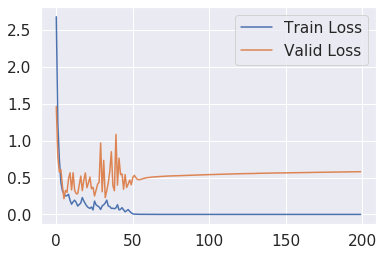

In [0]:
net = create_network()
adam = tf.optimizers.Adam(0.1)
net.compile(adam, 'sparse_categorical_crossentropy', ['accuracy'])
net.fit(X_train_norm, y_train, validation_data=(X_valid_norm, y_valid), epochs=200, batch_size=128, verbose=False)

train_loss = net.history.history['loss']
valid_loss = net.history.history['val_loss']

plt.figure()
plt.plot(train_loss, label="Train Loss")
plt.plot(valid_loss, label="Valid Loss")
_ = plt.legend()

# We could see the same trend is exposed in the learning curve figure.
# The "Valid Loss" slightly increases as the training continue after 50 epoch, however, the amount
# of increasement is strongly depend on the learning rate and which optimization algorithm used
# * SGD: the increment is very small when learning rate is smaller than 0.8, however, the algorithm
#        saturated with higher learning rate
# * Adam: the increment is significant with learning rate > 0.05

### **e)** Test some fast training algorithms on the simulation data.

* fast training algorithm with momentum
* fast training algorithm with adaptive learning rate

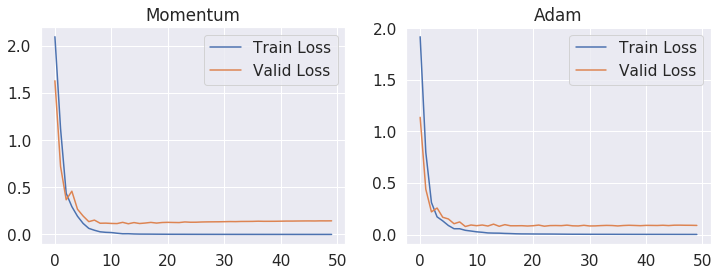

In [0]:
# Your code here
net1 = create_network()
# momentum take into account the "acceleration" of the gradient to adjust it value
# nesterov momentum also take into account the "accleration" of the "acceleration" of the gradient for adjustment.
sgd = tf.optimizers.SGD(0.1, momentum=0.9, nesterov=False)
net1.compile(sgd, 'sparse_categorical_crossentropy', ['accuracy'])
net1.fit(X_train_norm, y_train, validation_data=(X_valid_norm, y_valid), epochs=30, batch_size=128, verbose=False)

# adaptive learning rate
net2 = create_network()
adam = tf.optimizers.Adam(0.01)
net2.compile(adam, 'sparse_categorical_crossentropy', ['accuracy'])
net2.fit(X_train_norm, y_train, validation_data=(X_valid_norm, y_valid), epochs=30, batch_size=128, verbose=False)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(net1.history.history['loss'], label="Train Loss")
plt.plot(net1.history.history['val_loss'], label="Valid Loss")
plt.title("Momentum")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(net2.history.history['loss'], label="Train Loss")
plt.plot(net2.history.history['val_loss'], label="Valid Loss")
plt.title("Adam")
plt.legend()

# We could see Adam converge faster and more stable, however, it is not gaurantee that Adam will
# give better result compared to SGD with momentum